In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, DBSCAN

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

**Loading dataset**

In [2]:
import kaggle
kaggle.api.authenticate() 
kaggle.api.dataset_download_files('uciml/german-credit', path='data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/uciml/german-credit


In [3]:
data = pd.read_csv('data/german_credit_data.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.tail()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
995,31,female,1,own,little,NaN,1736,12,furniture/equipment
996,40,male,3,own,little,little,3857,30,car
997,38,male,2,own,little,NaN,804,12,radio/TV
998,23,male,2,free,little,little,1845,45,radio/TV
999,27,male,2,own,moderate,moderate,4576,45,car


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


There are customers who do not have a current account, a savings account, or both. Let's add a new feature value:

In [5]:
data.fillna('none', inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [7]:
data.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


## Distribution of features

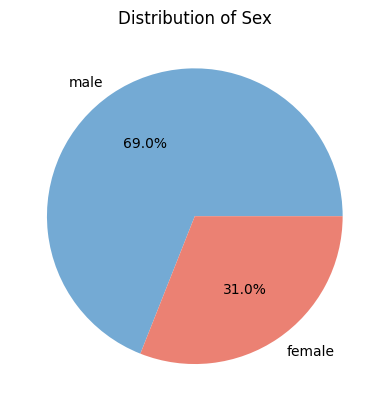

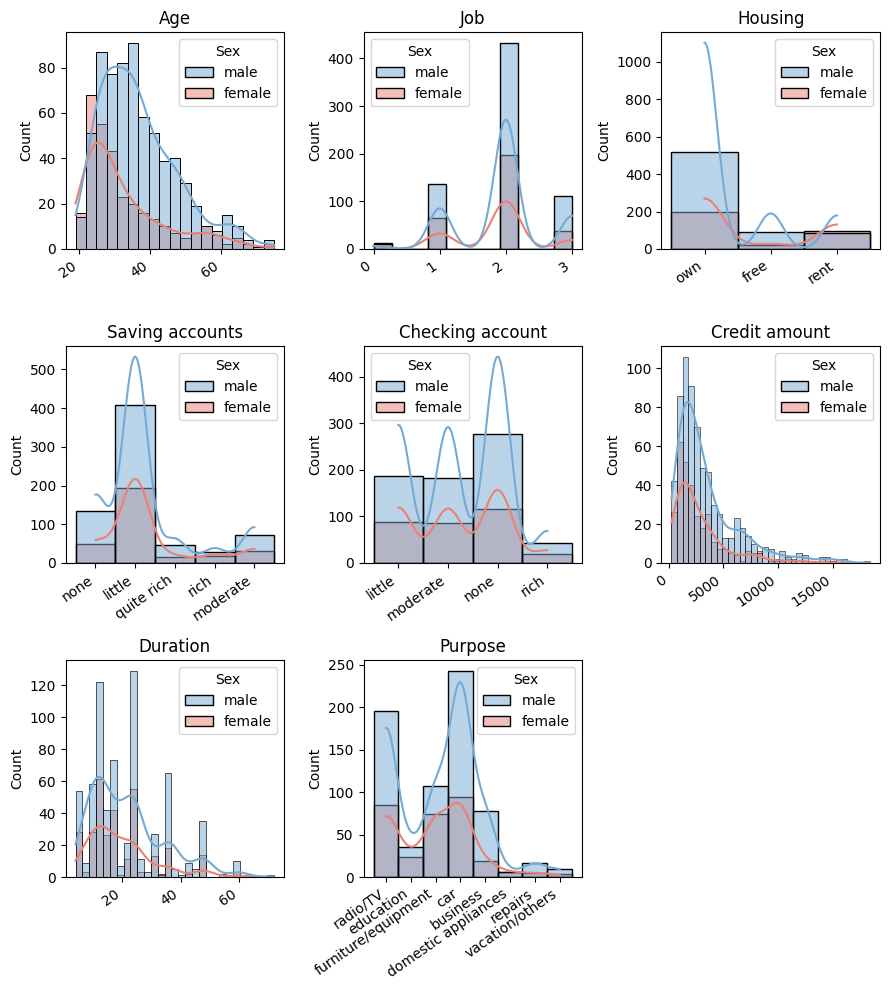

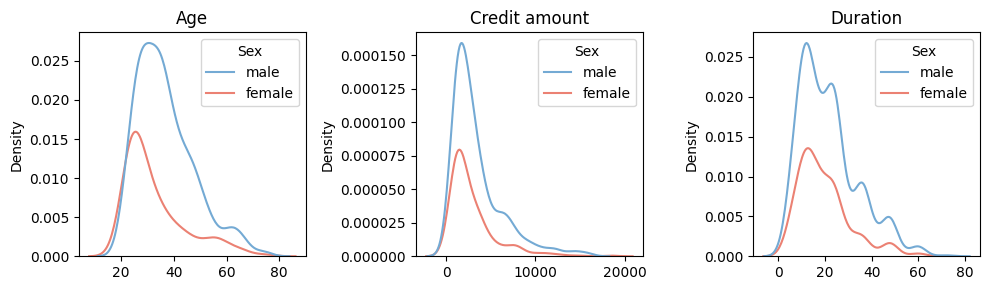

In [8]:
plt.pie(data['Sex'].value_counts(),
        autopct='%1.1f%%',
        labels=data['Sex'].unique(),
        colors=['#74aad4', '#eb8173'])
plt.title('Distribution of Sex')
plt.show()

plt.figure(figsize=(9, 10))
dist = data.drop('Sex', axis=1)

for i, col in enumerate(dist.columns):
    plt.subplot(3, 3, i+1).set_title(col)
    sns.histplot(data=dist, x=dist.columns[i], hue=data['Sex'], kde=True, palette=['#74aad4', '#eb8173'])
    plt.xticks(rotation=35, ha='right')
    plt.xlabel('')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))
dist = data.drop(['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'], axis=1)

for i, col in enumerate(dist.columns):
    plt.subplot(1, 3, i+1).set_title(col)
    sns.kdeplot(data=dist, x=dist.columns[i], hue=data['Sex'], palette=['#74aad4', '#eb8173'])
    plt.xlabel('')

plt.tight_layout()
plt.show()

## Encoding

Encode `Saving accounts` & `Checking account`

In [9]:
data_code = data.copy()

In [10]:
data_code = data_code.replace({'none': 0,
                               'little': 1,
                               'quite rich': 2,
                               'rich': 3,
                               'moderate': 4})

Other categorical features:

In [11]:
ohe = OneHotEncoder(use_cat_names=True)

data_code = data_code.drop(['Sex', 'Housing', 'Purpose'], axis = 1).join(ohe.fit_transform(data_code[['Sex', 'Housing', 'Purpose']], axis = 0))

data_code.tail()

,Age,Job,Saving accounts,Checking account,Credit amount,Duration,Sex_male,Sex_female,Housing_own,Housing_free,Housing_rent,Purpose_radio/TV,Purpose_education,Purpose_furniture/equipment,Purpose_car,Purpose_business,Purpose_domestic appliances,Purpose_repairs,Purpose_vacation/others
995,31,1,1,0,1736,12,0,1,1,0,0,0,0,1,0,0,0,0,0
996,40,3,1,1,3857,30,1,0,1,0,0,0,0,0,1,0,0,0,0
997,38,2,1,0,804,12,1,0,1,0,0,1,0,0,0,0,0,0,0
998,23,2,1,1,1845,45,1,0,0,1,0,1,0,0,0,0,0,0,0
999,27,2,4,4,4576,45,1,0,1,0,0,0,0,0,1,0,0,0,0


## Scaling

In [12]:
scaler = MinMaxScaler()
X = scaler.fit_transform(data_code)

X.shape

(1000, 19)

## Dimension Reduction

In [13]:
tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
X_tsne = tsne.fit_transform(X)

pca = PCA(n_components=2, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X)

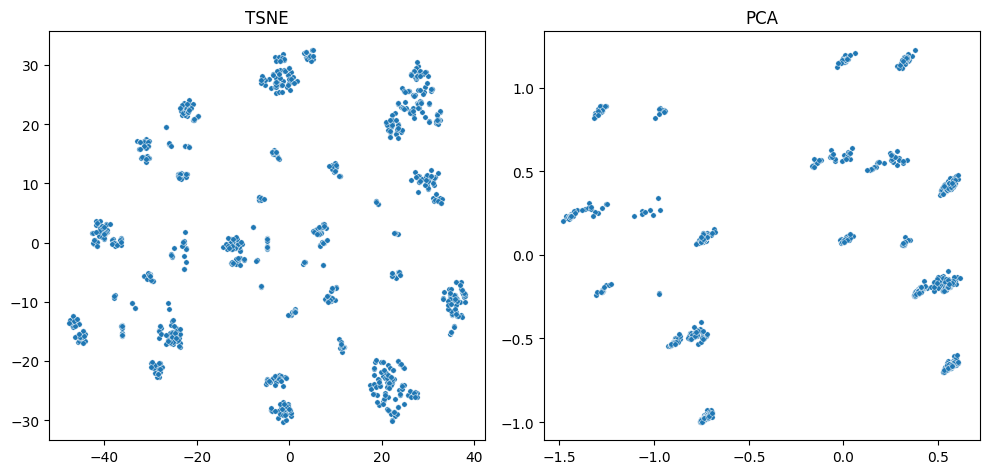

In [14]:
def clust_plots(X_tsne, X_pca, title=None, hue=None):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=hue, palette='rainbow', s=15)
    plt.title('TSNE')

    plt.subplot(1, 2, 2)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=hue, palette='rainbow', s=15)
    plt.title('PCA')

    plt.suptitle(title)

    plt.tight_layout()
    plt.show()

clust_plots(X_tsne, X_pca, hue=None)

# Models

## K-means

**Elbow method & Silhouette Score**

100%|██████████| 9/9 [00:00<00:00, 59.02it/s]


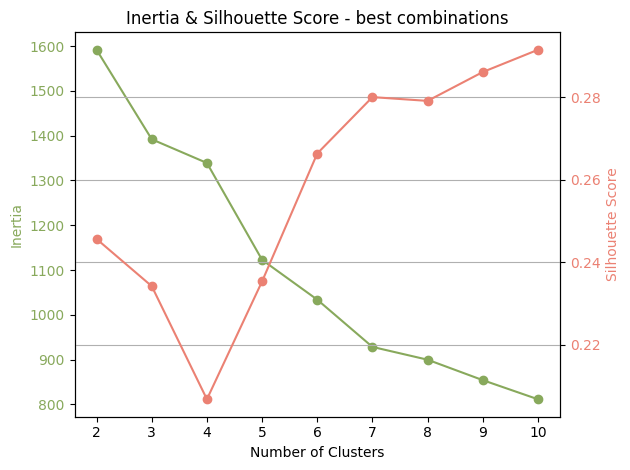

In [15]:
inertia = []
score_kmeans = []
for n_clusters in tqdm(np.arange(2,11)):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=RANDOM_SEED).fit(X)
    
    inertia_clusters = kmeans.inertia_
    inertia.append(inertia_clusters)

    clustering = kmeans.predict(X)
    silhouette = silhouette_score(X, clustering)
    score_kmeans.append(silhouette)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Number of Clusters')
plt.xticks(np.arange(2, 11, 1))
ax1.set_ylabel('Inertia', color='#88a95c')
ax1.plot(np.arange(2, 11), inertia, marker='o', color='#88a95c')
ax1.tick_params(axis='y', labelcolor='#88a95c')

ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='#eb8173')
ax2.plot(np.arange(2, 11), score_kmeans, marker='o', color='#eb8173')
ax2.tick_params(axis='y', labelcolor='#eb8173')

plt.title('Inertia & Silhouette Score - best combinations')
plt.tight_layout()
plt.grid(True)
plt.show()

**Visualization**

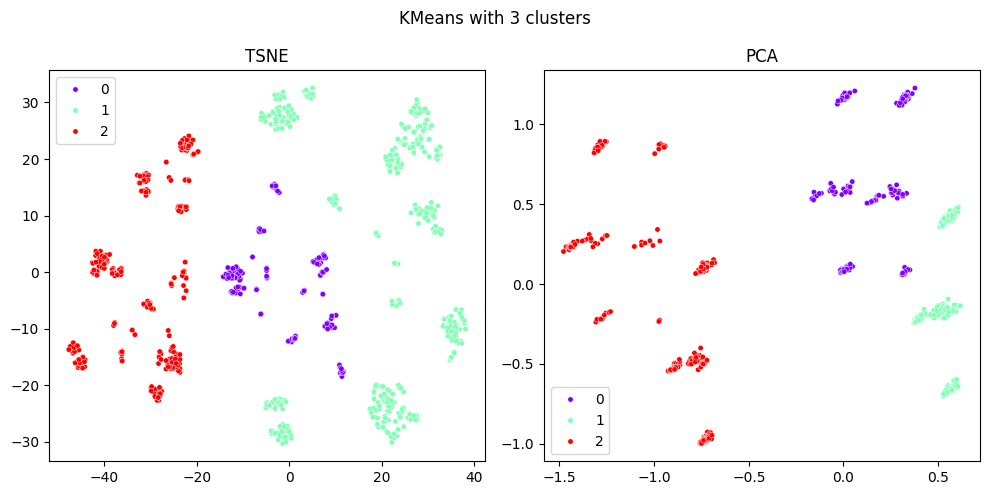

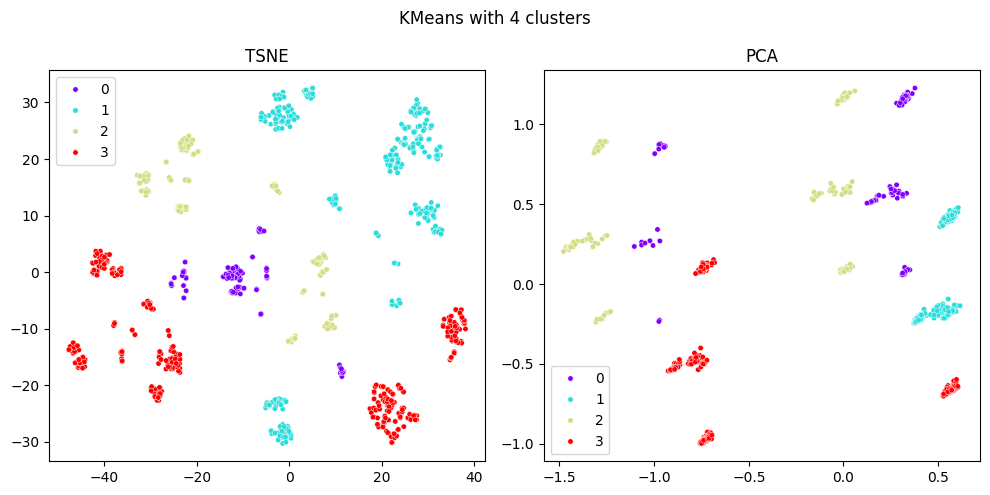

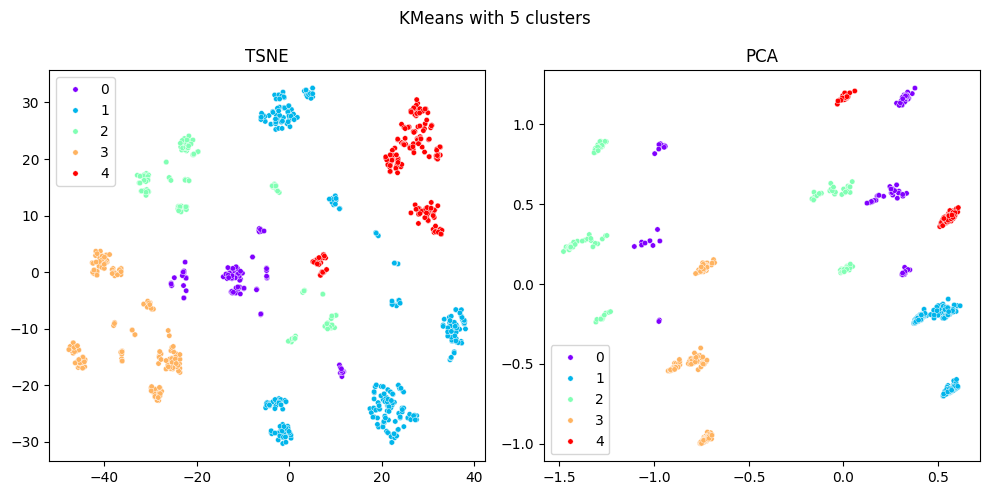

In [16]:
kmeans3 = KMeans(n_clusters=3, random_state=RANDOM_SEED, n_init='auto').fit(X)
labels_kmeans3 = kmeans3.labels_

kmeans4 = KMeans(n_clusters=4, random_state=RANDOM_SEED, n_init='auto').fit(X)
labels_kmeans4 = kmeans4.labels_

kmeans5 = KMeans(n_clusters=5, random_state=RANDOM_SEED, n_init='auto').fit(X)
labels_kmeans5 = kmeans5.labels_

clust_plots(X_tsne, X_pca, title='KMeans with 3 clusters', hue=labels_kmeans3)
clust_plots(X_tsne, X_pca, title='KMeans with 4 clusters', hue=labels_kmeans4)
clust_plots(X_tsne, X_pca, title='KMeans with 5 clusters', hue=labels_kmeans5)

## DBSCAN

**Silhouette Score vs. Epsilon**

100%|██████████| 7/7 [00:00<00:00, 65.64it/s]


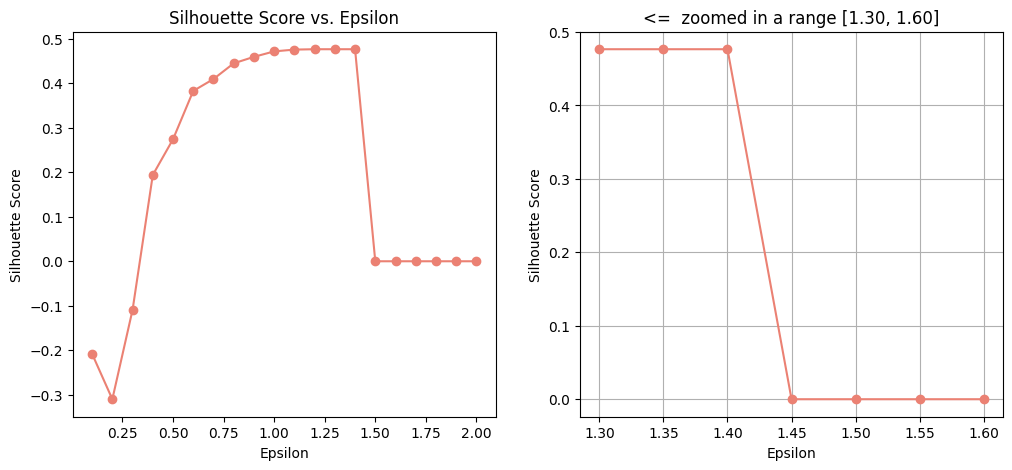

In [17]:
eps1 = np.arange(0.1, 2.1, 0.1)
score_dbscan1 = []
for eps in tqdm(eps1):
    dbscan1 = DBSCAN(eps=eps, min_samples=5).fit(X)
    labels1 = dbscan1.labels_
    uniq_labels = np.unique(labels1)
    n_clusters = len(uniq_labels[uniq_labels != -1])
    if n_clusters > 1:
        silhouette = silhouette_score(X, labels1)
    else:
        silhouette = 0
    score_dbscan1.append(silhouette)

eps2 = np.arange(1.3, 1.6, 0.05)
score_dbscan2 = []
for eps in tqdm(eps2):
    dbscan2 = DBSCAN(eps=eps, min_samples=5).fit(X)
    labels2 = dbscan2.labels_
    uniq_labels = np.unique(labels2)
    n_clusters = len(uniq_labels[uniq_labels != -1])
    if n_clusters > 1:
        silhouette = silhouette_score(X, labels2)
    else:
        silhouette = 0
    score_dbscan2.append(silhouette)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(eps1, score_dbscan1, marker='o', color='#eb8173')
ax1.set_title('Silhouette Score vs. Epsilon')
ax1.set_xlabel('Epsilon')
ax1.set_ylabel('Silhouette Score')
plt.grid(True)

ax2.plot(eps2, score_dbscan2, marker='o', color='#eb8173')
ax2.set_title('<=  zoomed in a range [1.30, 1.60]')
ax2.set_xlabel('Epsilon')
ax2.set_ylabel('Silhouette Score')
plt.grid(True)

plt.show()

100%|██████████| 50/50 [00:00<00:00, 53.13it/s]


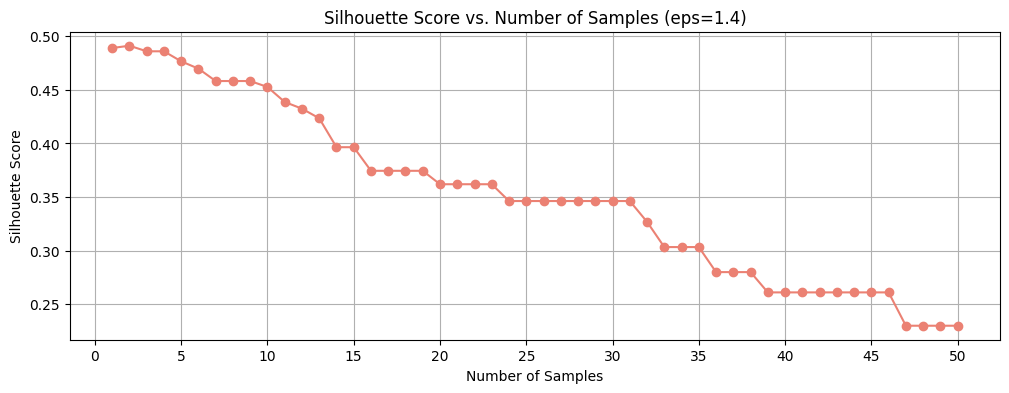

In [18]:
score_dbscan3 = []
samples = np.arange(1, 51, 1)
for min_samples in tqdm(samples):
    dbscan3 = DBSCAN(eps=1.4, min_samples=min_samples).fit(X)
    labels3 = dbscan3.labels_
    uniq_labels = np.unique(labels3)
    n_clusters = len(uniq_labels[uniq_labels != -1])
    if n_clusters > 1:
        silhouette = silhouette_score(X, labels3)
    else:
        silhouette = 0
    score_dbscan3.append(silhouette)

plt.figure(figsize=(12, 4))
plt.plot(samples, score_dbscan3, marker='o', color='#eb8173')
plt.title('Silhouette Score vs. Number of Samples (eps=1.4)')
plt.xlabel('Number of Samples')
plt.xticks(np.arange(0, max(samples)+2, 5))
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

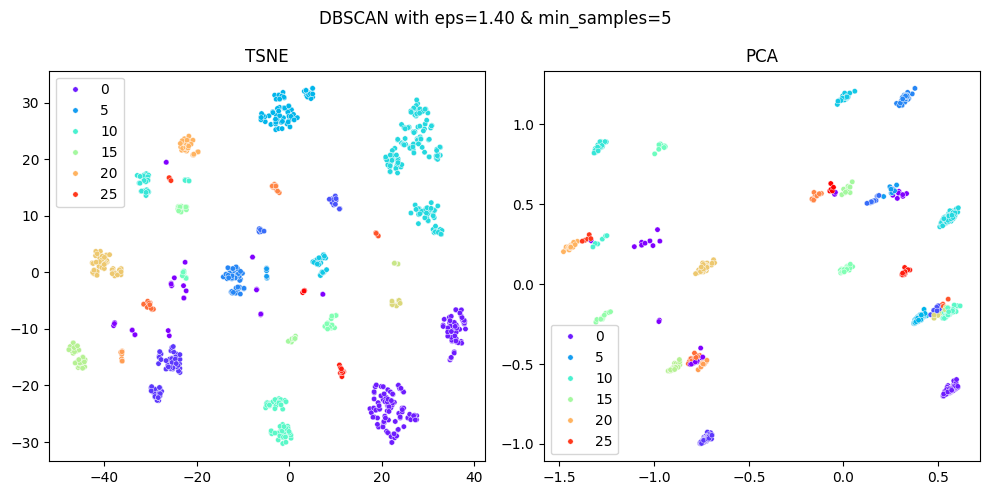

In [19]:
dbscan = DBSCAN(eps=1.40, min_samples=5).fit(X)
labels_dbscan = dbscan.labels_

clust_plots(X_tsne, X_pca, title='DBSCAN with eps=1.40 & min_samples=5', hue=labels_dbscan)

## AgglomerativeClustering

**Silhouette Score**

100%|██████████| 20/20 [00:00<00:00, 28.27it/s]


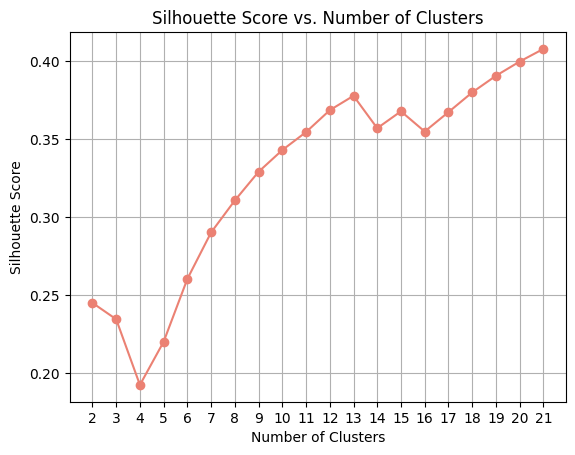

In [20]:
score_agg = []
for n_clusters in tqdm(np.arange(2, 22)):
    agg = AgglomerativeClustering(n_clusters=n_clusters).fit(X)
    clustering = agg.fit_predict(X)
    
    silhouette = silhouette_score(X, clustering)
    score_agg.append(silhouette)

plt.plot(np.arange(2, 22), score_agg, marker='o', color='#eb8173')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.xticks(np.arange(2, 22, 1))
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

**Dendrogram**

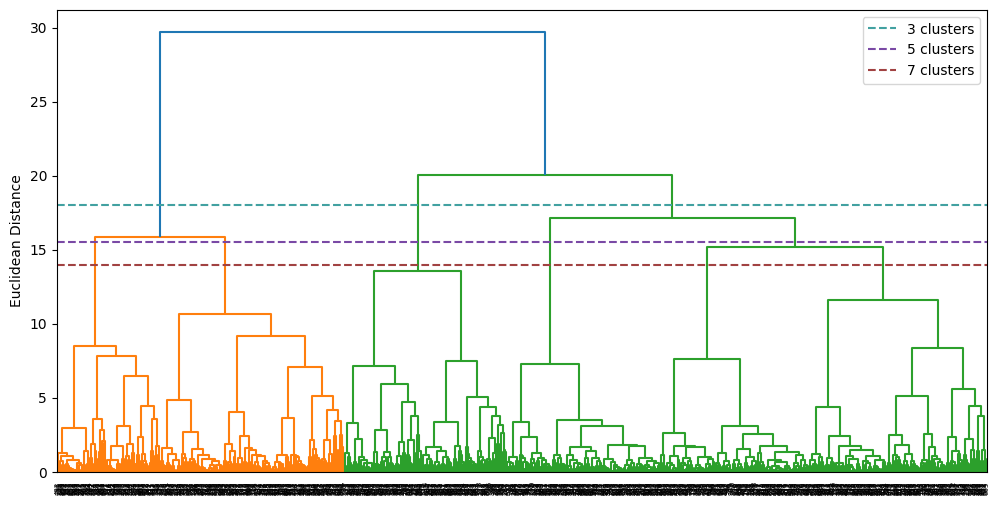

In [21]:
plt.figure(figsize=(12, 6))
linkage = linkage(X, method='ward')
dendrogram = dendrogram(linkage)
plt.axhline(y=18, c='#42A1A1', linestyle='--', label='3 clusters')
plt.axhline(y=15.5, c='#7a49a5', linestyle='--', label='5 clusters')
plt.axhline(y=14, c='#a14242', linestyle='--', label='7 clusters')
plt.ylabel('Euclidean Distance')
plt.legend()
plt.show()

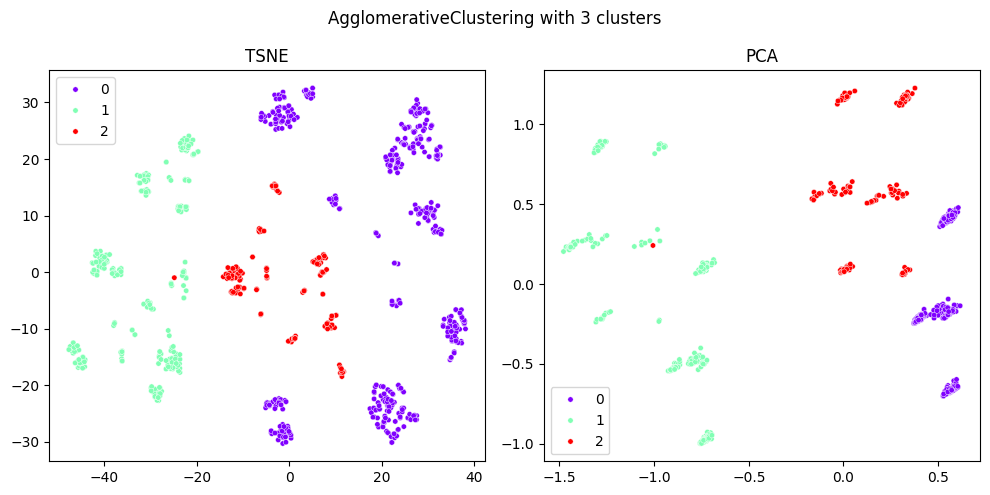

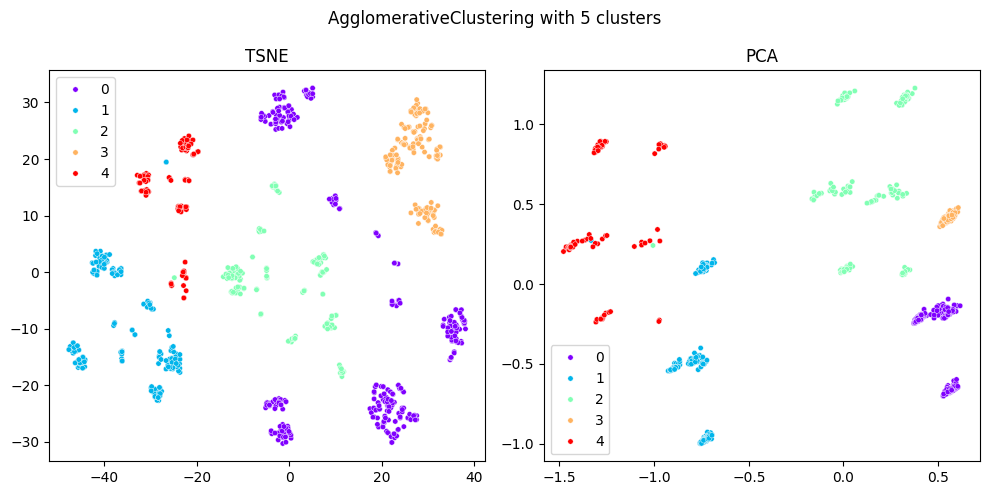

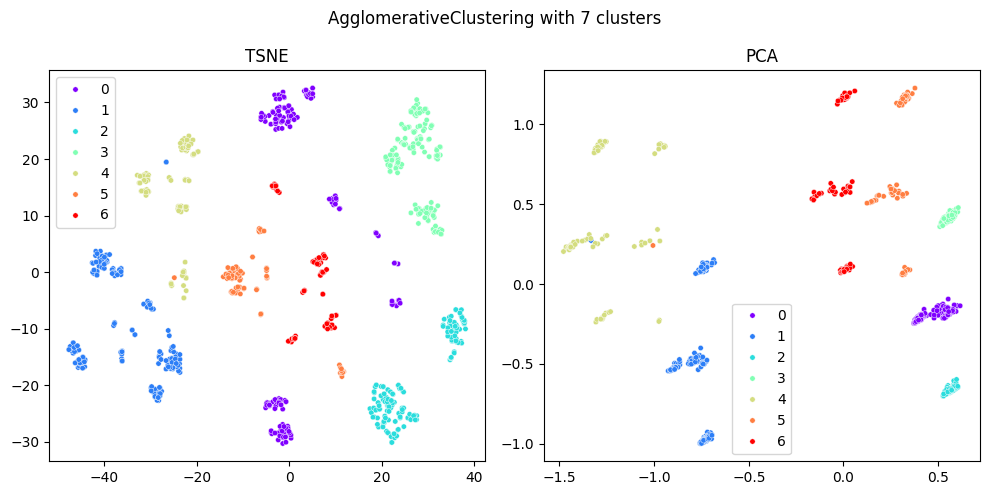

In [22]:
agg3 = AgglomerativeClustering(n_clusters=3).fit(X)
labels_agg3 = agg3.labels_

agg5 = AgglomerativeClustering(n_clusters=5).fit(X)
labels_agg5 = agg5.labels_

agg7 = AgglomerativeClustering(n_clusters=7).fit(X)
labels_agg7 = agg7.labels_

clust_plots(X_tsne, X_pca, title='AgglomerativeClustering with 3 clusters', hue=labels_agg3)
clust_plots(X_tsne, X_pca, title='AgglomerativeClustering with 5 clusters', hue=labels_agg5)
clust_plots(X_tsne, X_pca, title='AgglomerativeClustering with 7 clusters', hue=labels_agg7)

# Interpretation

In [23]:
clustered_data = data.assign(Cluster=labels_kmeans5)
clustered_data = clustered_data.sort_values('Cluster').reset_index(drop=True)
clustered_data.tail()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Cluster
995,44,male,2,own,moderate,moderate,1804,12,car,4
996,48,male,1,rent,little,little,2241,10,car,4
997,27,male,2,own,moderate,moderate,4576,45,car,4
998,50,male,2,own,none,none,2390,12,car,4
999,40,male,3,own,little,little,3857,30,car,4


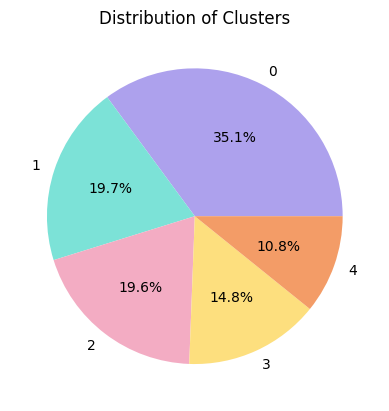

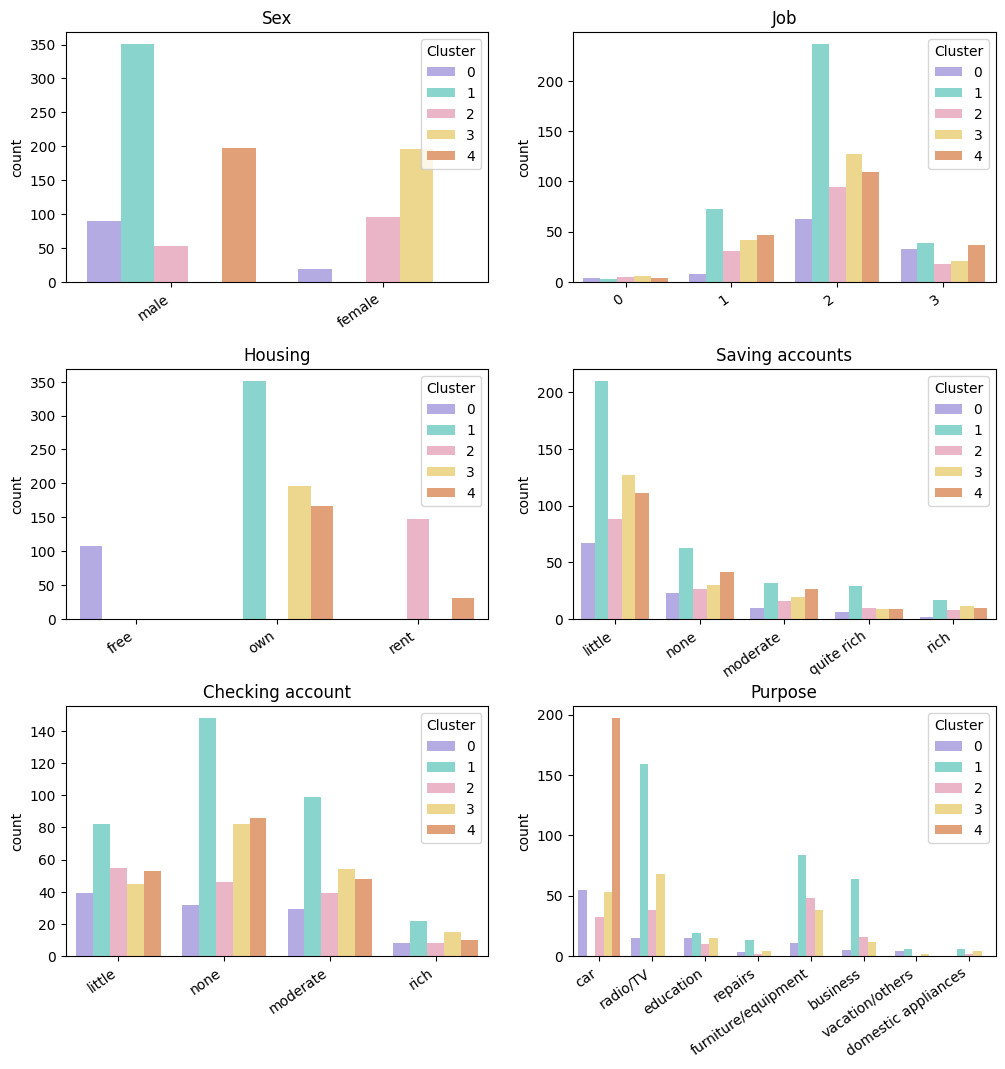

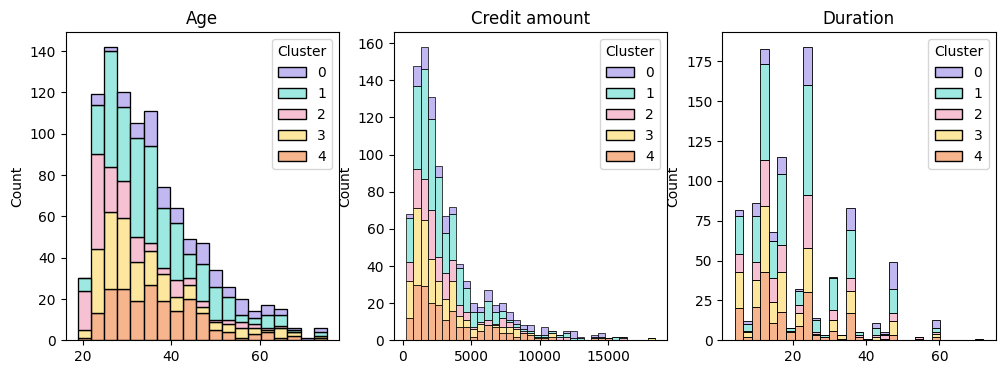

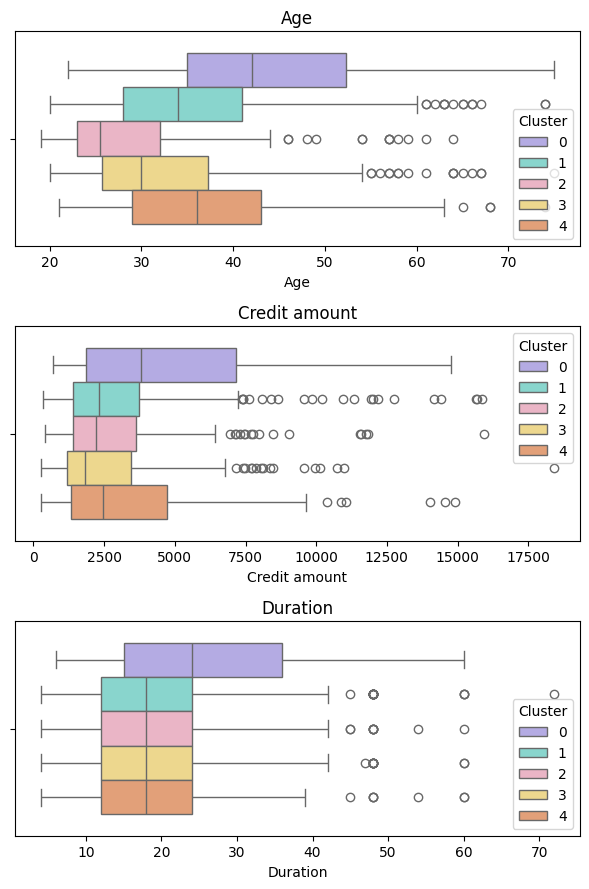

In [24]:
colors = ['#ada1ed', '#7ce2d7', '#f3acc3', '#fddf7e', '#f39c67']

plt.pie(clustered_data['Cluster'].value_counts(),
        autopct='%1.1f%%',
        labels=clustered_data['Cluster'].unique(),
        colors=colors)
plt.title('Distribution of Clusters')

plt.figure(figsize=(12, 12))
clustered_dist = clustered_data.drop(['Age', 'Credit amount', 'Duration', 'Cluster'], axis=1)
for i, col in enumerate(clustered_dist.columns):
    plt.subplot(3, 2, i+1).set_title(col)
    sns.countplot(data=clustered_dist, x=clustered_dist.columns[i], hue=clustered_data['Cluster'], palette=colors)
    plt.xticks(rotation=35, ha='right')
    plt.subplots_adjust(hspace = 0.35)
    plt.xlabel('')

plt.figure(figsize=(12, 4))
clustered_dist = clustered_data.drop(['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'], axis=1)
for i, col in enumerate(dist.columns):
    plt.subplot(1, 3, i+1).set_title(col)
    sns.histplot(data=clustered_dist, x=clustered_dist.columns[i], hue=clustered_data['Cluster'], multiple='stack', palette=colors)
    plt.xlabel('')

plt.figure(figsize=(6, 9))
for i, col in enumerate(clustered_dist.columns[:-1]):
    plt.subplot(3, 1, i+1).set_title(col)
    sns.boxplot(data=clustered_dist, x=clustered_dist.columns[i], hue='Cluster', palette=colors)

plt.tight_layout()
plt.show()

In [25]:
grouped_mean = clustered_data.copy()
grouped_mean = grouped_mean.drop(['Sex', 'Job', 'Housing', 'Saving accounts',
                                  'Checking account', 'Purpose'], axis=1)
grouped_mean = grouped_mean.groupby(['Cluster']).mean()

grouped_mode = clustered_data.copy()
grouped_mode = grouped_mode.drop(['Age', 'Credit amount', 'Duration'], axis=1)
grouped_mode = grouped_mode.groupby(['Cluster']).agg(lambda x: x.mode().iloc[0])

grouped_data = pd.concat([grouped_mode, grouped_mean], axis=1)

grouped_data = grouped_data.rename(columns={'Sex': 'Sex (mode)',
                                            'Job': 'Job (mode)', 
                                            'Housing': 'Housing (mode)',
                                            'Saving accounts': 'Saving accounts (mode)',
                                            'Checking account': 'Checking account (mode)',
                                            'Purpose': 'Purpose (mode)',
                                            'Age': 'Age (mean)',
                                            'Credit amount': 'Credit amount (mean)',
                                            'Duration': 'Duration (mean)'})

grouped_data

,Sex (mode),Job (mode),Housing (mode),Saving accounts (mode),Checking account (mode),Purpose (mode),Age (mean),Credit amount (mean),Duration (mean)
Cluster,,,,,,,,,
0,male,2,free,little,little,car,43.814815,4906.212963,27.453704
1,male,2,own,little,none,radio/TV,35.880342,3057.652422,21.236467
2,female,2,rent,little,little,furniture/equipment,29.337838,3069.101351,20.074324
3,female,2,own,little,none,radio/TV,33.668367,2683.556122,19.204082
4,male,2,own,little,none,car,36.949239,3492.116751,19.030457
